Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# 3D Multi-organ Segmentation with Swin UNETR  (BTCV Challenge)


This tutorial uses a Swin UNETR [1] model for the task of multi-organ segmentation task using the BTCV challenge dataset. The architecture of Swin UNETR is demonstrated as below

![image](../figures/swin_unetr_btcv.png)

The following features are included in this tutorial:
1. Transforms for dictionary format data.
1. Define a new transform according to MONAI transform API.
1. Load Nifti image with metadata, load a list of images and stack them.
1. Randomly adjust intensity for data augmentation.
1. Cache IO and transforms, ThreadDataLoader, and AMP to accelerate training and validation.
1. Swin UNETR model, DiceCE loss function, Mean Dice metric for multi-organ segmentation task.

For this tutorial, the dataset needs to be downloaded from: https://www.synapse.org/#!Synapse:syn3193805/wiki/217752. More details are provided in the "Download dataset" section below.

In addition, the json file for data splits needs to be downloaded from this [link](https://drive.google.com/file/d/1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi/view?usp=sharing). Once downloaded, place the json file in the same folder as the dataset.

For BTCV dataset, under Institutional Review Board (IRB) supervision, 50 abdomen CT scans of were randomly selected from a combination of an ongoing colorectal cancer chemotherapy trial, and a retrospective ventral hernia study. The 50 scans were captured during portal venous contrast phase with variable volume sizes (512 x 512 x 85 - 512 x 512 x 198) and field of views (approx. 280 x 280 x 280 mm3 - 500 x 500 x 650 mm3). The in-plane resolution varies from 0.54 x 0.54 mm2 to 0.98 x 0.98 mm2, while the slice thickness ranges from 2.5 mm to 5.0 mm.

- Target: 13 abdominal organs including
    1. Spleen
    2. Right Kidney
    3. Left Kidney
    4. Gallbladder
    5. Esophagus
    6. Liver
    7. Stomach
    8. Aorta
    9. IVC
    10. Portal and Splenic Veins
    11. Pancreas
    12. Right adrenal gland
    13. Left adrenal gland.
- Modality: CT
- Size: 30 3D volumes (24 Training + 6 Testing)
- Challenge: BTCV MICCAI Challenge

The following figure shows image patches with the organ sub-regions that are annotated in the CT (top left) and the final labels for the whole dataset (right).

Data, figures and resources are taken from:


1. [Self-Supervised Pre-Training of Swin Transformers
for 3D Medical Image Analysis](https://arxiv.org/abs/2111.14791)

2. [Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images](https://arxiv.org/abs/2201.01266)

3. [High-resolution 3D abdominal segmentation with random patch network fusion (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841520302589)

4. [Efficient multi-atlas abdominal segmentation on clinically acquired CT with SIMPLE context learning (MIA)](https://www.sciencedirect.com/science/article/abs/pii/S1361841515000766?via%3Dihub)


![image](../figures/BTCV_organs.png)



The image patches show anatomies of a subject, including:
1. large organs: spleen, liver, stomach.
2. Smaller organs: gallbladder, esophagus, kidneys, pancreas.
3. Vascular tissues: aorta, IVC, P&S Veins.
4. Glands: left and right adrenal gland

If you find this tutorial helpful, please consider citing [1] and [2]:

[1]: Tang, Y., Yang, D., Li, W., Roth, H.R., Landman, B., Xu, D., Nath, V. and Hatamizadeh, A., 2022. Self-supervised pre-training of swin transformers for 3d medical image analysis. In Proceedings of the IEEE/CVF Conference on Computer Vision and Pattern Recognition (pp. 20730-20740).

[2]: Hatamizadeh, A., Nath, V., Tang, Y., Yang, D., Roth, H. and Xu, D., 2022. Swin UNETR: Swin Transformers for Semantic Segmentation of Brain Tumors in MRI Images. arXiv preprint arXiv:2201.01266.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_segmentation/swin_unetr_btcv_segmentation_3d.ipynb)


# Pre-trained Swin UNETR Encoder

We use weights from self-supervised pre-training of Swin UNETR encoder (3D Swin Tranformer) on a cohort of 5050 CT scans from publicly available datasets. The encoder is pre-trained using reconstructin, rotation prediction and contrastive learning pre-text tasks as shown below. For more details, please refer to [1] (CVPR paper) and see this [repository](https://github.com/Project-MONAI/research-contributions/tree/main/SwinUNETR/Pretrain).

![image](https://lh3.googleusercontent.com/pw/AM-JKLVLgduGZ9naCSasWg09U665NBdd3UD4eLTy15wJiwbmKLS_p5WSZ2MBcRePEJO2tv9X3TkC52MsbnomuPy5JT3vSVeCji1MOEuAzcsxily88TdbHuAt6PzccefwKupbXyOCumK5hzz5Ul38kZnlEQ84=w397-h410-no?authuser=2)

Please download the pre-trained weights from this [link](../figures/swin.png) and place it in the root directory of this tutorial.

If training from scratch is desired, please skip the step for initializing from pre-trained weights.

## Setup environment

In [1]:
!python -c "import monai; import nibabel; import tqdm" || pip install -q "monai-weekly[nibabel, tqdm, einops]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import monai
import nibabel
import tqdm
import numpy as np
import gc

/home/nimesh/anaconda3/envs/myenv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Setup imports

In [3]:
import os
import shutil
import tempfile

import matplotlib.pyplot as plt
from tqdm import tqdm

from monai.losses import DiceCELoss
from monai.inferers import sliding_window_inference
from monai.transforms import (
    AsDiscrete,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandFlipd,
    RandCropByPosNegLabeld,
    RandShiftIntensityd,
    ScaleIntensityRanged,
    Spacingd,
    RandRotate90d,
    EnsureTyped,
)

from monai.config import print_config
from monai.metrics import DiceMetric
from monai.networks.nets import SwinUNETR

from monai.data import (
    ThreadDataLoader,
    CacheDataset,
    load_decathlon_datalist,
    decollate_batch,
    set_track_meta,
)


import torch
torch.cuda.empty_cache() 

print_config()

MONAI version: 1.4.dev2350
Numpy version: 1.26.2
Pytorch version: 2.1.1+cu121
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: e54c05d7a659e4d402f5194412889779e6856cbd
MONAI __file__: /home/<username>/anaconda3/envs/myenv/lib/python3.11/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: NOT INSTALLED or UNKNOWN VERSION.
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.1.0
scikit-image version: 0.22.0
scipy version: 1.11.4
Pillow version: 10.1.0
Tensorboard version: NOT INSTALLED or UNKNOWN VERSION.
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: NOT INSTALLED or UNKNOWN VERSION.
tqdm version: 4.65.0
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 2.1.4
einops version: 0.7.0
transformers version: NOT INSTALLED or UNKNOWN VERSION.
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version:

## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmpuyrv_j73


## Setup transforms for training and validation
To save on GPU memory utilization, the num_samples can be reduced to 2.

A note on design related to MetaTensors:

- Summary: using `EnsureTyped(..., track_meta=False)` (caching) and `set_track_meta(False)` (during training) speeds up training significantly.

- We are moving towards the use of MONAI's MetaTensor in place of numpy arrays or PyTorch tensors. MetaTensors have the benefit of carrying the metadata directly with the tensor, but in some use cases (like here with training, where training data are only used for computing loss and metadata is not useful), we can safely disregard the metadata to improve speed.

- Hence, you will see `EnsureTyped` being used before the first random transform in the training transform chain, which caches the result of deterministic transforms on GPU as Tensors (rather than MetaTensors), with `track_meta = False`.

- On the other hand, in the following demos we will display example validation images, which uses metadata, so we use `EnsureTyped` with `track_meta = True`. Since there are no random transforms during validation, tracking metadata for validation images causes virtually no slowdown (~0.5%).

- In the next section, you will see `set_track_meta(False)`. This is a global API introduced in MONAI 0.9.1, and it makes sure that random transforms will also be performed using Tensors rather than MetaTensors. Used together with `track_meta=False` in `EnsureTyped`, it results in all transforms being performed on Tensors, which we have found to speed up training.

In [5]:
num_samples = 4

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-175,
            a_max=250,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #     keys=["image", "label"],
        #     pixdim=(1.5, 1.5, 2.0),
        #     mode=("bilinear", "nearest"),
        # ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=False),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=num_samples,
            image_key="image",
            image_threshold=0,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[0],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[1],
            prob=0.10,
        ),
        RandFlipd(
            keys=["image", "label"],
            spatial_axis=[2],
            prob=0.10,
        ),
        RandRotate90d(
            keys=["image", "label"],
            prob=0.10,
            max_k=3,
        ),
        RandShiftIntensityd(
            keys=["image"],
            offsets=0.10,
            prob=0.50,
        ),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"], ensure_channel_first=True),
        ScaleIntensityRanged(keys=["image"], a_min=-175, a_max=250, b_min=0.0, b_max=1.0, clip=True),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        # Spacingd(
        #     keys=["image", "label"],
        #     pixdim=(1.5, 1.5, 2.0),
        #     mode=("bilinear", "nearest"),
        # ),
        EnsureTyped(keys=["image", "label"], device=device, track_meta=True),
    ]
)

/home/nimesh/anaconda3/envs/myenv/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.croppad.dictionary CropForegroundd.__init__:allow_smaller: Current default value of argument `allow_smaller=True` has been deprecated since version 1.2. It will be changed to `allow_smaller=False` in version 1.5.
  warn_deprecated(argname, msg, warning_category)


## Download dataset and format in the folder
1. Download dataset from here: https://www.synapse.org/#!Synapse:syn3193805/wiki/89480. After you open the link, navigate to the "Files" tab, then download Abdomen/RawData.zip.

    Note that you may need to register for an account on Synapse and consent to use agreements before being able to view/download this file. There are options to download directly from the browser or from the command line; please refer to Synapse API documentation for more info.


2. After downloading the zip file, unzip. Then put images from `RawData/Training/img` in `./data/imagesTr`, and put labels from `RawData/Training/label` in `./data/labelsTr`.


3. Make a JSON file to define train/val split and other relevant parameters. Place the JSON file at `./data/dataset_0.json`.

    You can download an example of the JSON file [here](https://drive.google.com/file/d/1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi/view?usp=sharing), or, equivalently, use the following `wget` command. If you would like to use this directly, please move it into the `./data` folder.

In [7]:
# uncomment this command to download the JSON file directly
# wget -O data/dataset_0.json 'https://drive.google.com/uc?export=download&id=1qcGh41p-rI3H_sQ0JwOAhNiQSXriQqGi'

In [8]:
data_dir = "../data/"
split_json = "dataset_0.json"

datasets = data_dir + split_json
datalist = load_decathlon_datalist(datasets, True, "training")
val_files = load_decathlon_datalist(datasets, True, "validation")
train_ds = CacheDataset(
    data=datalist,
    transform=train_transforms,
    cache_num=24,
    cache_rate=1.0,
    num_workers=8,
)
train_loader = ThreadDataLoader(train_ds, num_workers=0, batch_size=1, shuffle=True)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_num=6, cache_rate=1.0, num_workers=4)
val_loader = ThreadDataLoader(val_ds, num_workers=0, batch_size=1)

# # as explained in the "Setup transforms" section above, we want cached training images to not have metadata, and validations to have metadata
# # the EnsureTyped transforms allow us to make this distinction
# # on the other hand, set_track_meta is a global API; doing so here makes sure subsequent transforms (i.e., random transforms for training)
# # will be carried out as Tensors, not MetaTensors
set_track_meta(False)

Loading dataset: 100%|██████████| 5/5 [00:01<00:00,  3.16it/s]


## Check data shape and visualize

image shape: torch.Size([1, 256, 256, 220]), label shape: torch.Size([1, 256, 256, 220])


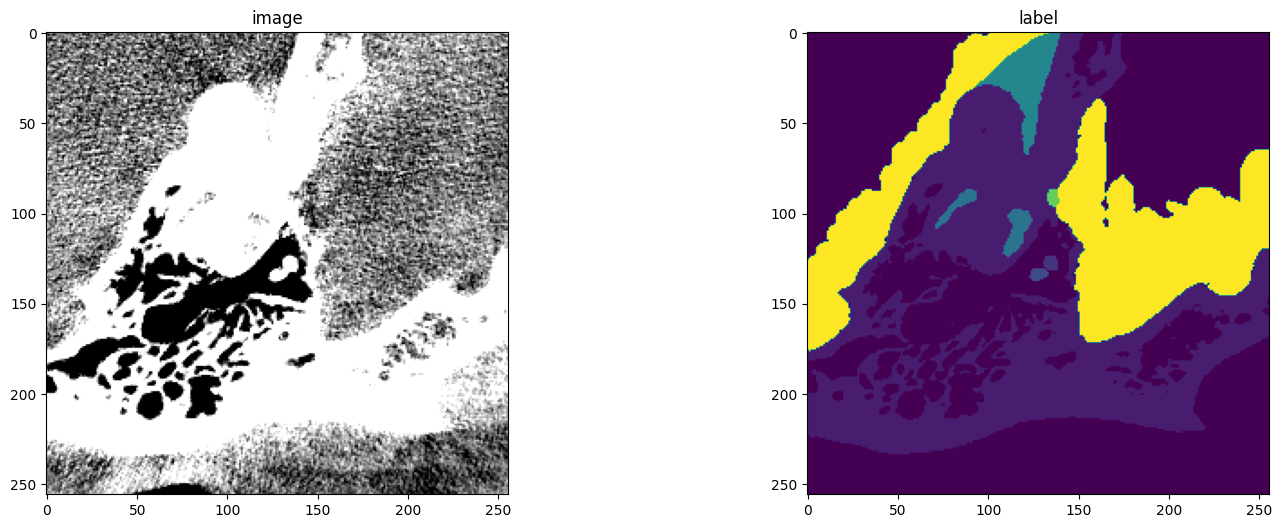

[ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16.]


In [9]:
# slice_map = {
#     "img0035.nii.gz": 170,
#     "img0036.nii.gz": 230,
#     "img0037.nii.gz": 204,
#     "img0038.nii.gz": 204,
#     "img0039.nii.gz": 204,
#     "img0040.nii.gz": 180,
# }
case_num = 0
slice_num = 133
img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
img = val_ds[case_num]["image"]
label = val_ds[case_num]["label"]
img_shape = img.shape
label_shape = label.shape
print(f"image shape: {img_shape}, label shape: {label_shape}")
plt.figure("image", (18, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(img[0, :, :, slice_num].detach().cpu(), cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0, :, :, slice_num].detach().cpu())
plt.show()

tlabel = label[0, :, :, :].detach().cpu().numpy()


### Create Swin UNETR model

In this section, we create a Swin UNETR model for the 14-class multi-organ segmentation. We use a feature size of 48, which is compatible with the self-supervised pre-trained weights. We also use gradient checkpointing (use_checkpoint) for more memory-efficient training.

In [10]:
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SwinUNETR(
    img_size=(96, 96, 96),
    in_channels=1,
    out_channels=17,
    feature_size=48,
    use_checkpoint=True,
).to(device)

/home/nimesh/anaconda3/envs/myenv/lib/python3.11/site-packages/monai/utils/deprecate_utils.py:221: FutureWarning: monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().
  warn_deprecated(argname, msg, warning_category)


### Initialize Swin UNETR encoder from self-supervised pre-trained weights

In this section, we intialize the Swin UNETR encoder from pre-trained weights. The weights can be downloaded using the wget command below, or by following [this link](https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt) to GitHub. If training from scratch is desired, please skip this section.

In [11]:
# uncomment to download the pre-trained weights
# !wget https://github.com/Project-MONAI/MONAI-extra-test-data/releases/download/0.8.1/model_swinvit.pt

In [12]:
weight = torch.load("../model_weights/model_swinvit.pt")
model.load_from(weights=weight)
print("Using pretrained self-supervied Swin UNETR backbone weights !")

Using pretrained self-supervied Swin UNETR backbone weights !


In [13]:
print(model)

SwinUNETR(
  (swinViT): SwinTransformer(
    (patch_embed): PatchEmbed(
      (proj): Conv3d(1, 48, kernel_size=(2, 2, 2), stride=(2, 2, 2))
    )
    (pos_drop): Dropout(p=0.0, inplace=False)
    (layers1): ModuleList(
      (0): BasicLayer(
        (blocks): ModuleList(
          (0-1): 2 x SwinTransformerBlock(
            (norm1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (attn): WindowAttention(
              (qkv): Linear(in_features=48, out_features=144, bias=True)
              (attn_drop): Dropout(p=0.0, inplace=False)
              (proj): Linear(in_features=48, out_features=48, bias=True)
              (proj_drop): Dropout(p=0.0, inplace=False)
              (softmax): Softmax(dim=-1)
            )
            (drop_path): Identity()
            (norm2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
            (mlp): MLPBlock(
              (linear1): Linear(in_features=48, out_features=192, bias=True)
              (linear2): Linear(in_feature

### Optimizer and loss function

In [14]:
torch.backends.cudnn.benchmark = True
loss_function = DiceCELoss(to_onehot_y=True, softmax=True)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
scaler = torch.cuda.amp.GradScaler()

### Execute a typical PyTorch training process

In [15]:
def validation(epoch_iterator_val):
    model.eval()
    with torch.no_grad():
        for batch in epoch_iterator_val:
            val_inputs, val_labels = (batch["image"].cuda(), batch["label"].cuda())
            with torch.cuda.amp.autocast():
                val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model)
            val_labels_list = decollate_batch(val_labels)
            val_labels_convert = [post_label(val_label_tensor) for val_label_tensor in val_labels_list]
            val_outputs_list = decollate_batch(val_outputs)
            val_output_convert = [post_pred(val_pred_tensor) for val_pred_tensor in val_outputs_list]
            dice_metric(y_pred=val_output_convert, y=val_labels_convert)
            epoch_iterator_val.set_description("Validate (%d / %d Steps)" % (global_step, 10.0))
        mean_dice_val = dice_metric.aggregate().item()
        dice_metric.reset()
    return mean_dice_val


def train(global_step, train_loader, val_loader, dice_val_best, global_step_best):
    model.train()
    epoch_loss = 0
    step = 0
    epoch_iterator = tqdm(train_loader, desc="Training (X / X Steps) (loss=X.X)", dynamic_ncols=True)
    for step, batch in enumerate(epoch_iterator):
        step += 1
        x, y = (batch["image"].cuda(), batch["label"].cuda())
        # print(x.shape)
        with torch.cuda.amp.autocast():
            logit_map = model(x)
            loss = loss_function(logit_map, y)
        scaler.scale(loss).backward()
        epoch_loss += loss.item()
        scaler.unscale_(optimizer)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
        epoch_iterator.set_description(f"Training ({global_step} / {max_iterations} Steps) (loss={loss:2.5f})")
        if (global_step % eval_num == 0 and global_step != 0) or global_step == max_iterations:
            epoch_iterator_val = tqdm(val_loader, desc="Validate (X / X Steps) (dice=X.X)", dynamic_ncols=True)
            dice_val = validation(epoch_iterator_val)
            epoch_loss /= step
            epoch_loss_values.append(epoch_loss)
            metric_values.append(dice_val)
            if dice_val > dice_val_best:
                dice_val_best = dice_val
                global_step_best = global_step
                torch.save(model.state_dict(), os.path.join(root_dir, "best_metric_model.pth"))
                print(
                    "Model Was Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(dice_val_best, dice_val)
                )
            else:
                print(
                    "Model Was Not Saved ! Current Best Avg. Dice: {} Current Avg. Dice: {}".format(
                        dice_val_best, dice_val
                    )
                )
        global_step += 1
    return global_step, dice_val_best, global_step_best

In [ ]:
max_iterations = 20000
eval_num = 500
post_label = AsDiscrete(to_onehot=17)
post_pred = AsDiscrete(argmax=True, to_onehot=17)
dice_metric = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
global_step = 0
dice_val_best = 0.0
global_step_best = 0
epoch_loss_values = []
metric_values = []
while global_step < max_iterations:
    global_step, dice_val_best, global_step_best = train(global_step, train_loader, val_loader, dice_val_best, global_step_best)
model.load_state_dict(torch.load(os.path.join(root_dir, "best_metric_model.pth")))
torch.save(model.state_dict(), "../model_weights/fold_0.pth")

In [ ]:
print(f"train completed, best_metric: {dice_val_best:.4f} " f"at iteration: {global_step_best}")

### Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Iteration Average Loss")
x = [eval_num * (i + 1) for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [eval_num * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("Iteration")
plt.plot(x, y)
plt.show()

### Check best model output with the input image and label

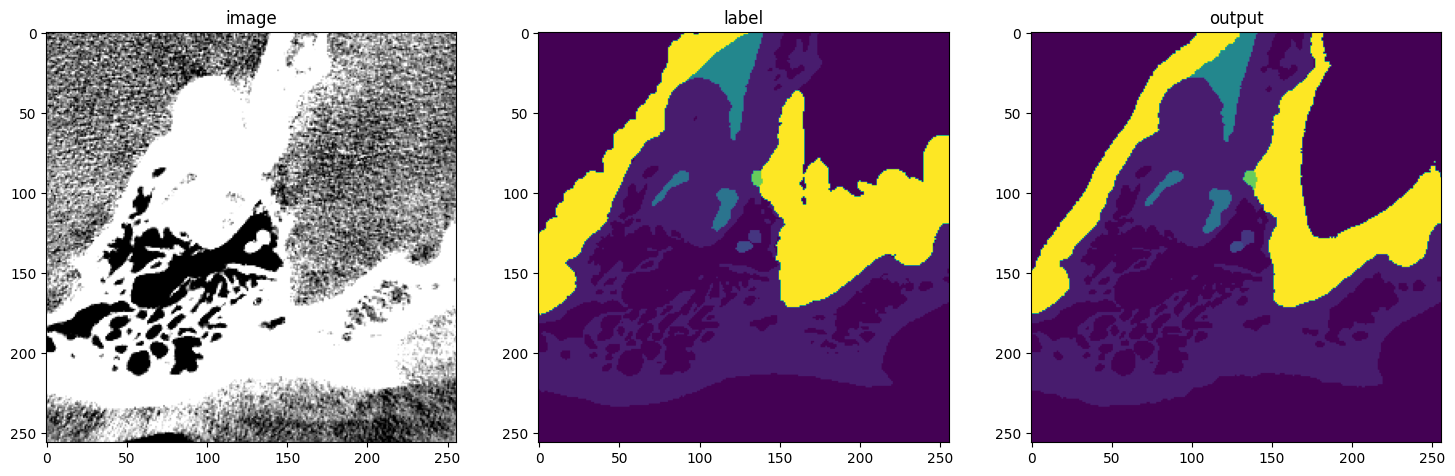

In [16]:
case_num = 0
slice_num = 133
weights_f = "../model_weights/fold_1_model.pth"
model.load_state_dict(torch.load(weights_f))
model.eval()
with torch.no_grad():
    img_name = os.path.split(val_ds[case_num]["image"].meta["filename_or_obj"])[1]
    img = val_ds[case_num]["image"]
    label = val_ds[case_num]["label"]
    val_inputs = torch.unsqueeze(img, 1).cuda()
    val_labels = torch.unsqueeze(label, 1).cuda()
    val_outputs = sliding_window_inference(val_inputs, (96, 96, 96), 4, model, overlap=0.8)
    plt.figure("check", (18, 6))
    plt.subplot(1, 3, 1)
    plt.title("image")
    plt.imshow(val_inputs.cpu().numpy()[0, 0, :, :, slice_num], cmap="gray")
    plt.subplot(1, 3, 2)
    plt.title("label")
    plt.imshow(val_labels.cpu().numpy()[0, 0, :, :, slice_num])
    plt.subplot(1, 3, 3)
    plt.title("output")
    plt.imshow(torch.argmax(val_outputs, dim=1).detach().cpu()[0, :, :, slice_num])
    plt.show()

### Cleanup data directory

Remove directory if a temporary was used.

In [ ]:
if directory is None:
    shutil.rmtree(root_dir)